# PA005 - High Value Customers Identification (Insiders)

## 0.0 Planejamento da Solução (IOT)

### Input - Entrada

1. Problema de negócio
- Selecionar os clientes mais valiosos para integrar um programa de fidelização.
2. Conjunto de Dados
- Vendas de um e-commerce, durante um certo período.

### Output  - Saída
1. A indicação das pessoas que farão parte do programa de Insiders.
- Lista: client_id| is_insider |

2. Relatório com as respostas das perguntas de negócio.
- Quem são as pessoas elegíveis para participar do programa de Insiders?
- Quantos clientes farão parte do grupo?
- Quais as principais características desses clientes?
- Qual a % de contribuição do faturamento, vinda do Insiders?
- Qual a expectativa de faturamento desse grupo para os próximos meses?
- Quais as condições para uma pessoa ser elegível ao Insiders?
- Quais as condições para uma pessoa ser removida do Insiders?
- Qual a garantia que o programa Insiders é melhor que o restante da base?
- Quais ações o time de marketing pode realizar para aumentar o faturamento?

### Tasks - Tarefas


1. Quem são as pessoas elegíveis para participar do programa de Insiders?
    - O que é ser elegível? O que são clientes de alto "valor"?
    - Faturamento:
        - Alto ticket médio.
        - Alto LTV.
        - Baixa Recência.
        - Alto basket size.
        - Baixa probabilidade de Churn.
        - Alta Previsão LTV.
        - Alta propensão de compra.

    - Custo:
        - Baixa taxa de devolução.
    
    - Experiência de compra:
        - Média alta das avaliações.

2. Quantos clientes farão parte do grupo?
    - Número total de clientes.
    - % do grupo Insiders.

3. Quais as principais características desses clientes?
    - Escrever características dos clientes:
        - Idade
        - Salário
        - Localização
    
    - Escrever características de consumo:
        - Atributos de clusterização

4. Qual a % de contribuição do faturamento, vinda do Insiders?
    - Faturamento total do ano.
    - Faturamento do grupo Insiders.

5. Qual a expectativa de faturamento desse grupo para os próximos meses?
    - Previsão do LTV do grupo Insiders.
    - Análise de Cohort.

6. Quais as condições para uma pessoa ser elegível ao Insiders?
    - Definir a periodicidade ( 1 mês, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa do grupo.
7. Quais as condições para uma pessoa ser removida do Insiders?
    - Definir a periodicidade ( 1 mês, 3 meses)
    - A pessoa precisa ser desimilar ou não-parecido com uma pessoa do grupo.
8. Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Teste A/B.
    - teste A/B Bayesiano.
    - Teste de hióteses.
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto.
    - Preferência de compra.
    - Frete.
    - Visita a empresa.

## Benchmark de soluções

### 1.0 Desk Research

# 0.0 Imports

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns

import umap.umap_ as umap

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from plotly import express as px
from matplotlib import pyplot as plt
from sklearn import cluster as c
from sklearn import metrics as mt

## 0.1 Helper Functions

## 0.2 Loading Dataset

In [2]:
# load data
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding='latin1')

# drop extra column
df_raw = df_raw.drop('Unnamed: 8', axis = 1)

# 1.0 Descrição dos Dados

In [3]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [4]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id','country']
df1.columns = cols_new

## 1.2 Data Dimensions, Types e NA

In [5]:
df1.shape

(541909, 8)

## 1.3 Datatypes

In [6]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [8]:
# remove na
df1 = df1.dropna(subset=['description','customer_id'])

print(f'Removed data: {1-(df1.shape[0] / df_raw.shape[0])}%')

Removed data: 0.24926694334288602%


## 1.6 Change Datatypes

In [9]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

## 1.7 Descriptive Statistics

# 2.0 Feature Enginnering

In [48]:
df2 = df1.copy()

## 2.1 Feature Creation

In [49]:
# data reference
df_ref = df2.drop(['invoice_no', 'stock_code', 'description','quantity','invoice_date','unit_price','country'], axis = 1).drop_duplicates(ignore_index = True)

In [50]:
# Gross Revenue (Faturamento) quantity * price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']
# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on ='customer_id', how='left')

# Recency - Last day purchase
df_recency = df2[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on ='customer_id', how='left')

# Frequency 
df_freq = df2[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on ='customer_id', how='left')

# Avg ticket
df_ticket = df2[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_ticket, on ='customer_id', how='left')


# 3.0 Filtragem de Variáveis

In [53]:
df3 = df_ref.copy()

# 4.0 EDA

In [54]:
df4 = df3.copy()

# 5.0 Data preparation

In [55]:
df5 = df4.copy()

# 6.0 Feature Selection

In [58]:
df6 = df5.copy()

# 7.0 HyperParameter Fine-Tunning

In [59]:
X = df6.drop(columns = ['customer_id'])

In [60]:
clusters = np.arange(2, 8, 1)

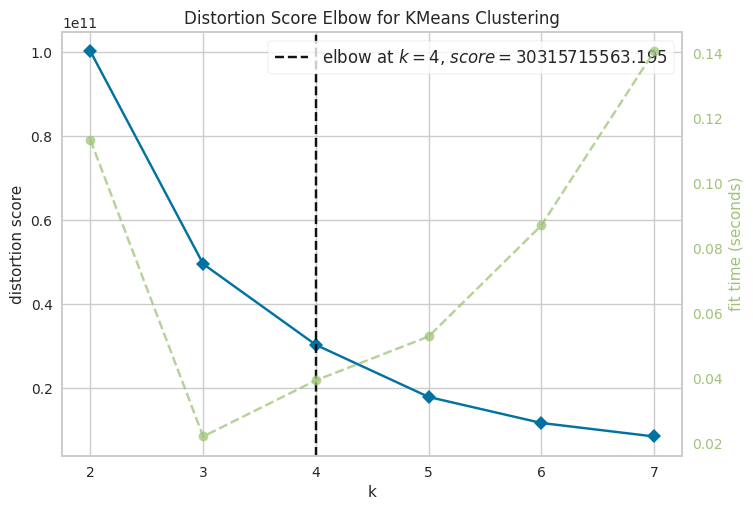

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [62]:
plt.rcParams['font.sans-serif'] = 'DejaVu Sans' 
kmeans = KElbowVisualizer (c.KMeans( n_init = 10), k=clusters, timing = True)
kmeans.fit(X)
kmeans.show()

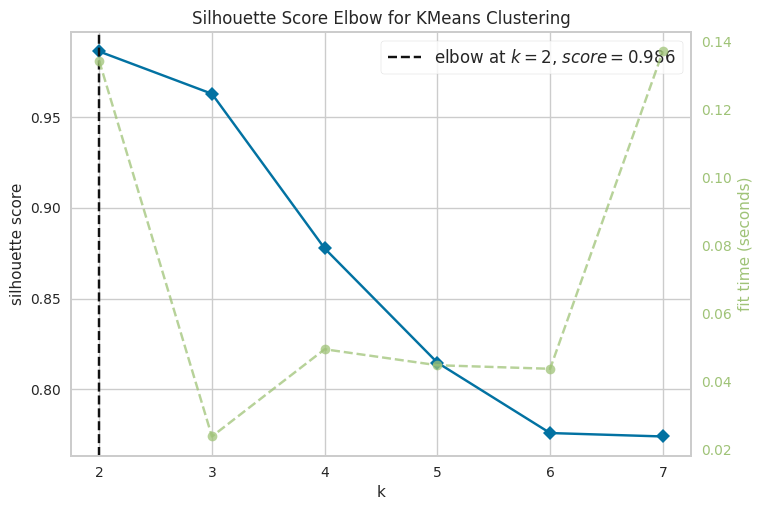

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [63]:
kmeans = KElbowVisualizer (c.KMeans( n_init = 10), k=clusters, metric='silhouette', timing = True)
kmeans.fit(X)
kmeans.show()

## 7.1 Silhouette Analysis

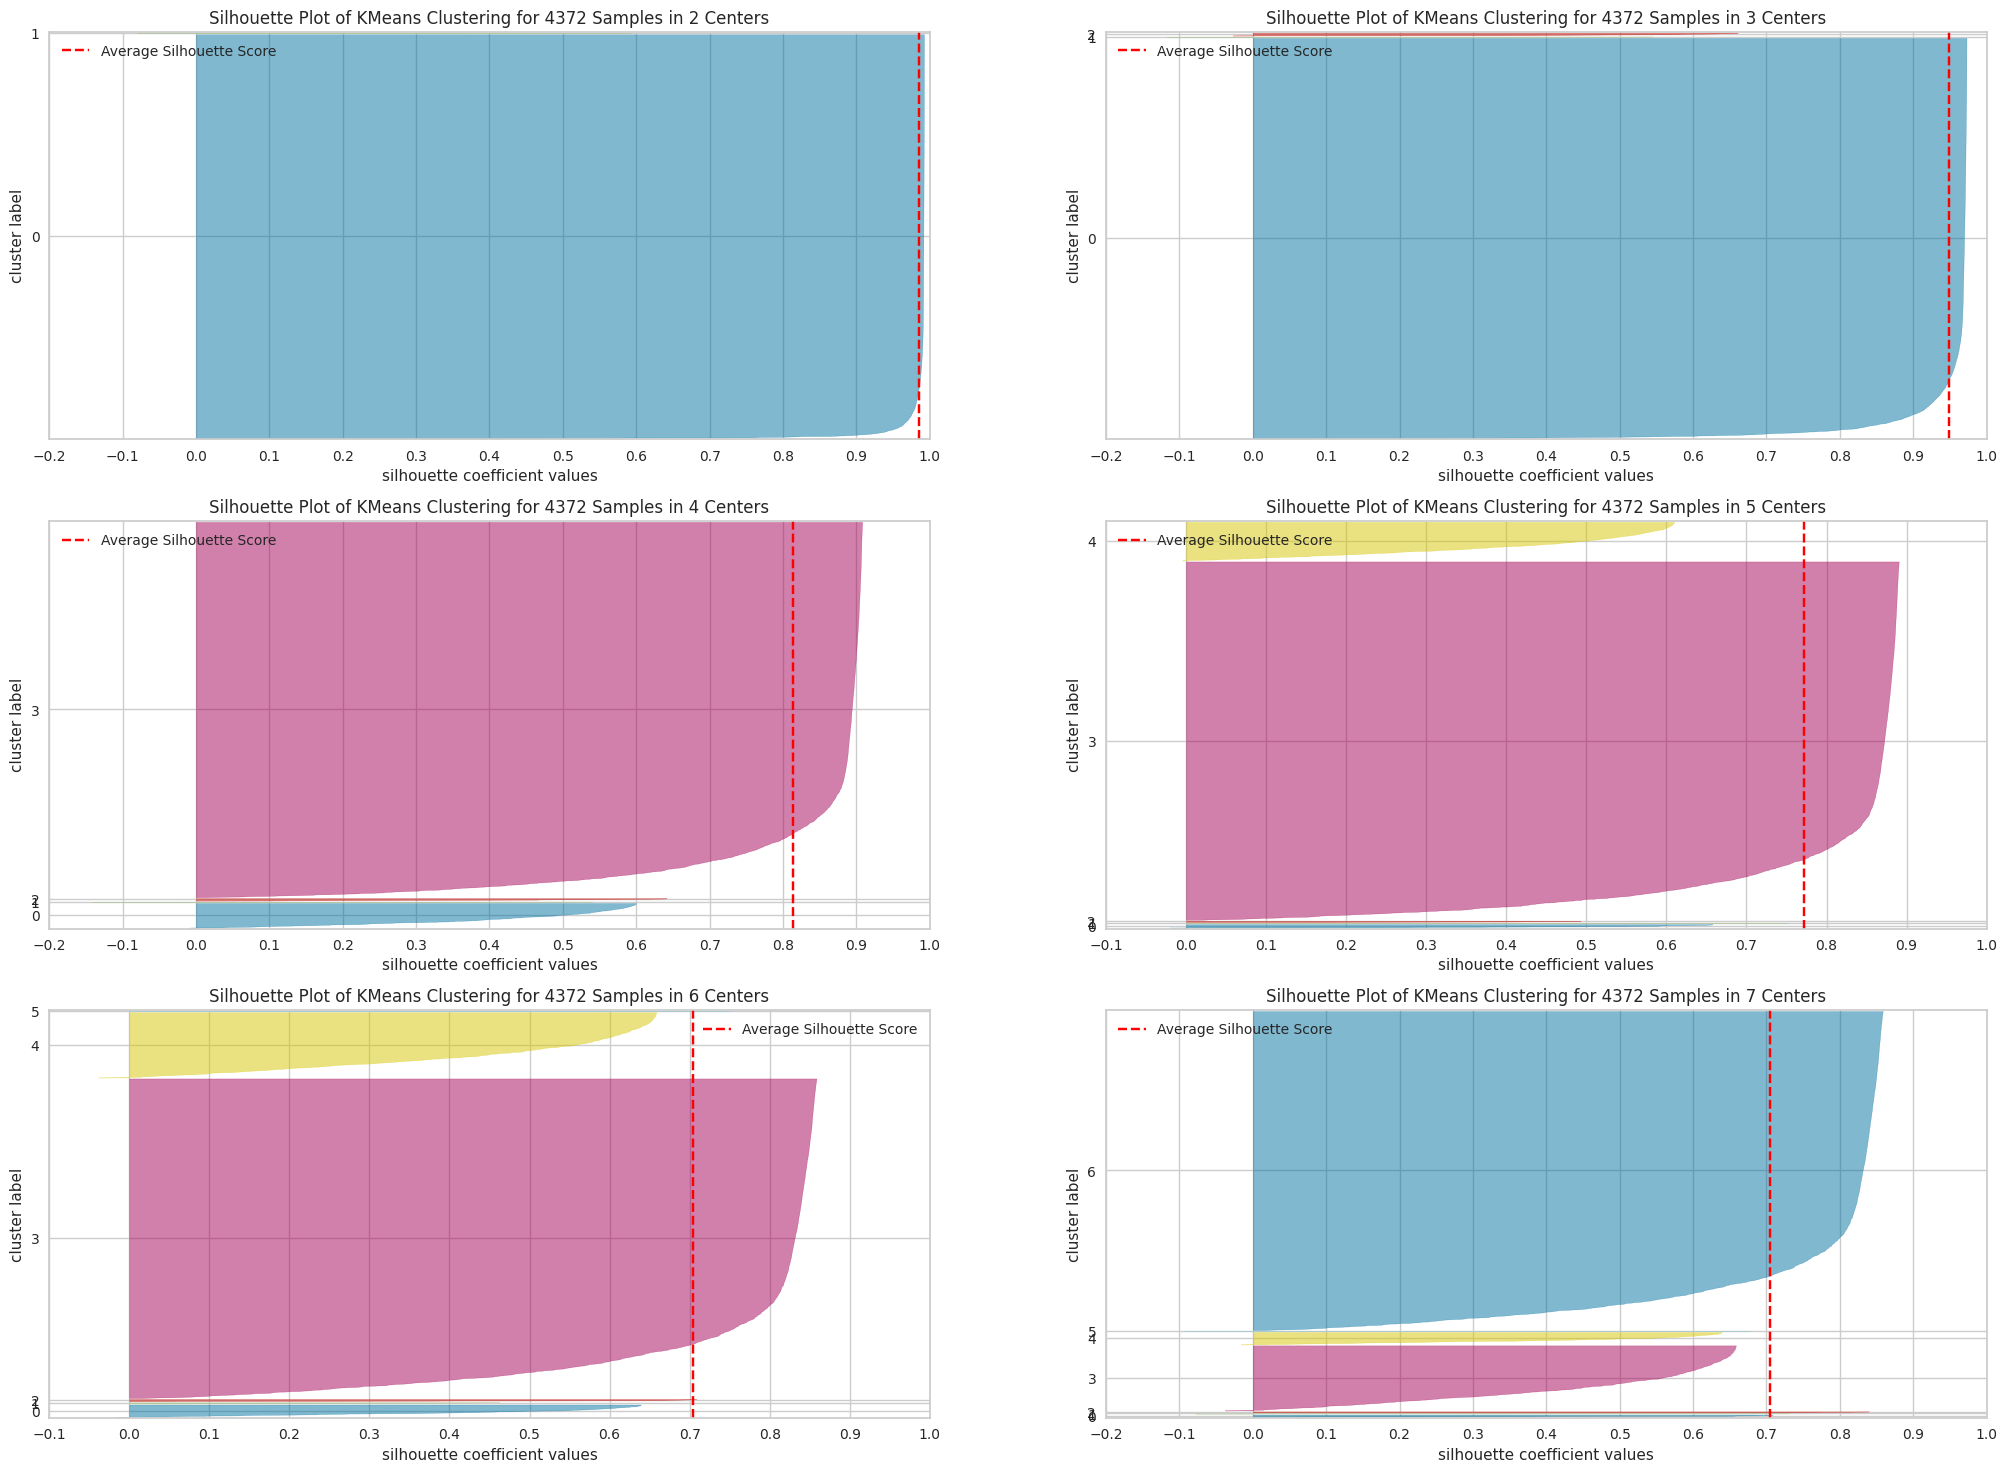

In [64]:
fig, ax = plt.subplots(3, 2, figsize=(25,18) )

for k in clusters:
    km = c.KMeans(n_clusters=k, n_init=10, init='random', max_iter = 100, random_state = 42)
    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax= ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0 Model Training

## 8.1 K-Means

In [65]:
# model definition
k = 4
kmeans = c.KMeans(init='random', n_clusters = k, n_init= 10, max_iter = 300, random_state = 42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.2 Cluster Validation

In [66]:
print(f'WSS:{kmeans.inertia_}')
print(f'SS:{mt.silhouette_score(X, labels)}')

WSS:40056506734.60243
SS:0.8139972028952444


# 9.0 Cluster Analysis

In [73]:
df9 = df6.copy()
df9['cluster'] = labels

## 9.1 Visualization Inspection Silhouette

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



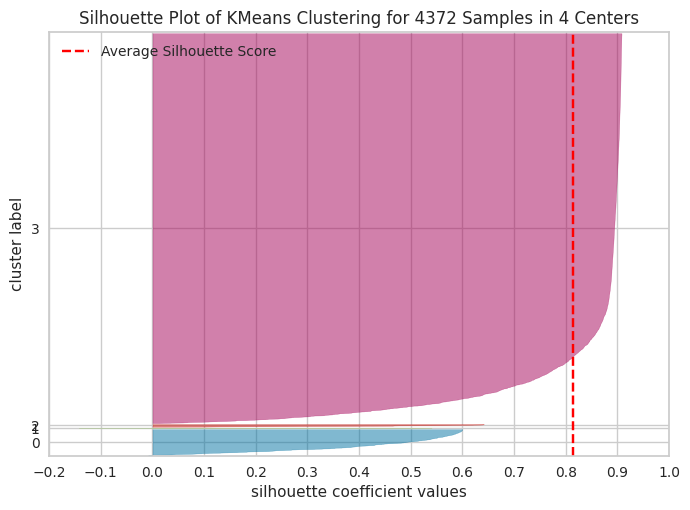

In [68]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2D Plot

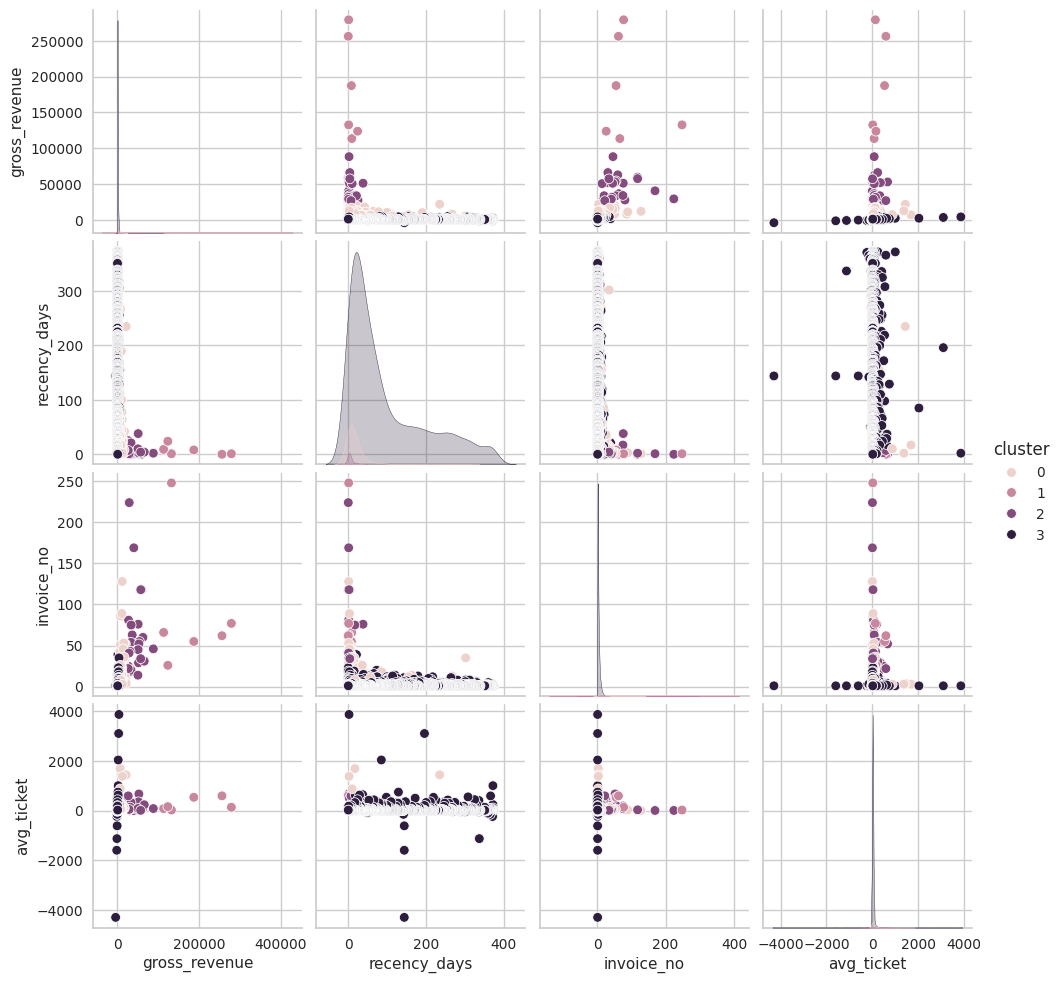

In [74]:
df_viz = df9.drop(columns='customer_id', axis = 1)
sns.pairplot(df_viz, hue = 'cluster')

## 9.3 UMAP

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



<Axes: xlabel='embedding_x', ylabel='embedding_y'>

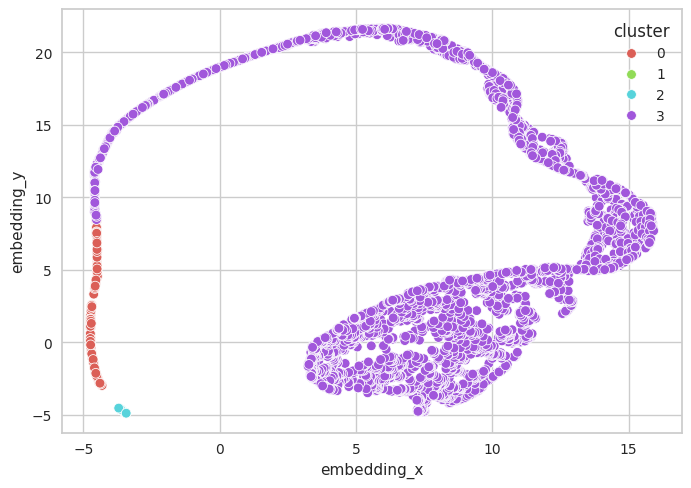

In [83]:
reducer = umap.UMAP(n_neighbors=30, random_state= 42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette = sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())), data = df_viz)


## 9.4 Cluster Profile

In [84]:
# Number of customers
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100* (df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg gross_revenue
df_gross = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_gross, on='cluster', how='left')

# Avg recency_days
df_recency_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days, on='cluster', how='left')

# Avg invoice_no
df_invoice_no = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, on='cluster', how='left')

# Avg ticket
df_ticket = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, on='cluster', how='left')
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,267,6.107045,8089.028652,20.280899,19.528090,62.783157
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,4071,93.115279,946.696250,96.969295,3.641120,25.359654


### Cluster 01: (Candidato à Insider)
    - Número de Customers: 6 (0.13% do customers)
    - Recência em Média: 7 dias
    - Compras em média no último ano: 89 compras
    - Receita em média no último ano: $182.182,00

### Cluster 02: 
    - Número de Customers: 31 (0.71% do customers)
    - Recência em Média: 14 dias
    - Compras em média no último ano: 53 compras
    - Receita em média no último ano: $40.543,52

### Cluster 03: 
    - Número de Customers: 4335 (99% do customers)
    - Recência em Média: 92 dias
    - Compras em média no último ano: 5 compras
    - Receita em média no último ano: $1.372,57

# 10.0 Deploy To Production